In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from utils import *
from debugger import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Latex-like font for plots
# Note: if LaTeX is not installed, do not run this cell
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr10",
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
    "font.size": 16})

### Efficiency test:
benchmark the time and memory efficiency increasing the Hilbert space dimension and using dense and sparse matrices.

In [3]:
# Set specific values for testing
g = 0.5
h = 0
N_max = 14
dense_lim = 12

In [4]:
# Prepare data
data = benchmark(maxDim=N_max, dense_limit=dense_lim, g=g, h=h)

# Store data into array
dims = np.array(data["hilbert_dims"])
t_sparse = np.array(data["time_sparse"])
m_sparse = np.array(data["mem_sparse"])
t_dense  = np.array(data["time_dense"])
m_dense  = np.array(data["mem_dense"])

Benchmarking Sparse vs Dense...
Benchmarking for N: 2/14
Benchmarking for N: 3/14
Benchmarking for N: 4/14
Benchmarking for N: 5/14
Benchmarking for N: 6/14
Benchmarking for N: 7/14
Benchmarking for N: 8/14
Benchmarking for N: 9/14
Benchmarking for N: 10/14
Benchmarking for N: 11/14
Benchmarking for N: 12/14
Benchmarking for N: 13/14
Benchmarking for N: 14/14
Benchmarking done!


In [5]:
# Fit data

# Fitting function
def f(x, a, b):
    return a * x**b

# Sparse fit on time
popt_t_sp, pcov_t_sp = curve_fit(f, dims, t_sparse)
# Dense fit on time
mask_dense = ~np.isnan(t_dense) # mask NaN values
if np.any(mask_dense):
    popt_t_de, pcov_t_de = curve_fit(f, dims[mask_dense], t_dense[mask_dense])

# Sparse fit on memory
popt_m_sp, pcov_m_sp = curve_fit(f, dims, m_sparse)
# Dense fit on memory
if np.any(mask_dense):
    popt_m_de, pcov_m_de = curve_fit(f, dims[mask_dense], m_dense[mask_dense], maxfev=10000)

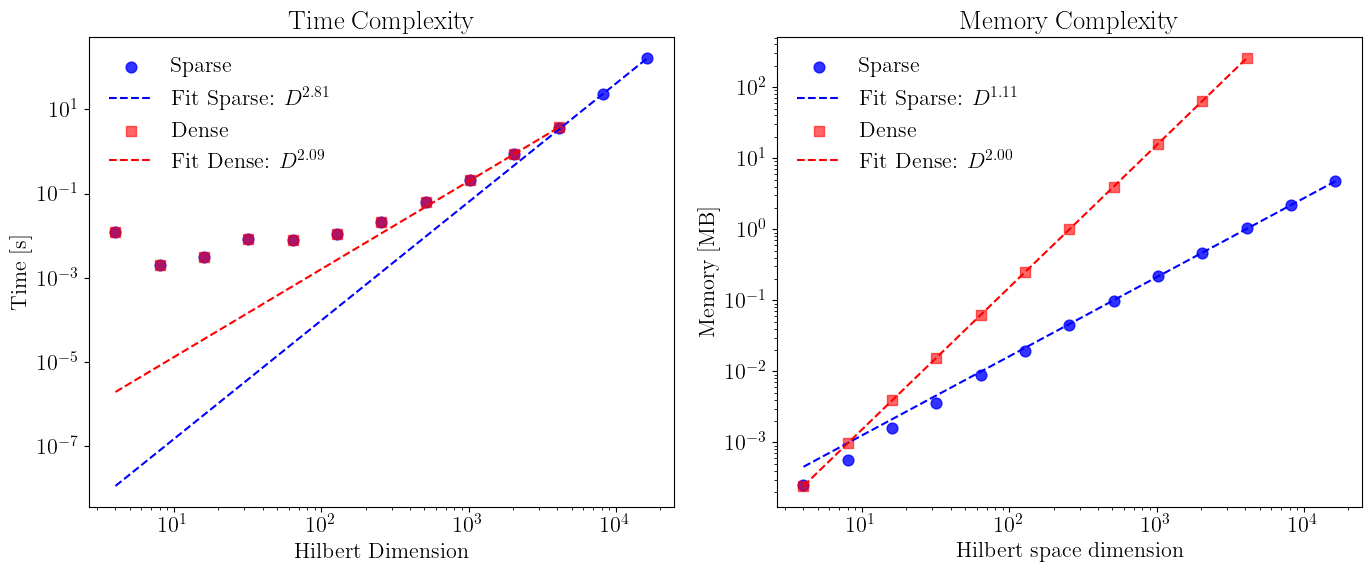

In [6]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# === Plot 1: TIME ===
ax1.set_xscale("log")
ax1.set_yscale("log")

# Sparse
ax1.scatter(dims, t_sparse, alpha=0.8, s=60, c="blue", label="Sparse")
ax1.plot(dims, f(dims, *popt_t_sp), c="blue", linestyle="dashed", label=f"Fit Sparse: $D^{{{popt_t_sp[1]:.2f}}}$")

# Dense
if np.any(mask_dense):
    ax1.scatter(dims, t_dense, alpha=0.6, s=60, c="red", marker='s', label="Dense")
    ax1.plot(dims[mask_dense], f(dims[mask_dense], *popt_t_de), c="red", linestyle="dashed", label=f"Fit Dense: $D^{{{popt_t_de[1]:.2f}}}$")

ax1.set_xlabel(r"Hilbert Dimension")
ax1.set_ylabel(r"Time [s]")
ax1.set_title("Time Complexity")
ax1.legend(frameon=False, loc="best")


# === Plot 2: MEMORY ===
ax2.set_xscale("log")
ax2.set_yscale("log")

# Sparse
ax2.scatter(dims, m_sparse, alpha=0.8, s=60, c="blue", label="Sparse")
ax2.plot(dims, f(dims, *popt_m_sp), c="blue", linestyle="dashed", label=f"Fit Sparse: $D^{{{popt_m_sp[1]:.2f}}}$")

# Dense
if np.any(mask_dense):
    ax2.scatter(dims, m_dense, alpha=0.6, s=60, c="red", marker='s', label="Dense")
    ax2.plot(dims[mask_dense], f(dims[mask_dense], *popt_m_de), c="red", linestyle="dashed", label=f"Fit Dense: $D^{{{popt_m_de[1]:.2f}}}$")

ax2.set_xlabel(r"Hilbert space dimension")
ax2.set_ylabel(r"Memory [MB]")
ax2.set_title("Memory Complexity")
ax2.legend(frameon=False, loc="best")

plt.tight_layout()
plt.savefig("benchmark_comparison.pdf")
plt.show()

### Diagonalize matrices increasing N to study the energy spectrum

In [7]:
# Control parameters
g_values = np.linspace(0, 3, 100)
h_values = [0, 0.01]
N_list = np.arange(1, N_max+1, 2)
k = 10 # number of energy levels to compute

# Diagonalization benchmark
results = {}

message_checkpoints(0, "Diagonalizing...", True)
for N in N_list:
    print(f"Diagonalizing for N: {N}/{N_list[-1]}")
    for h in h_values:
        spectrum = []

        for g in g_values:
            # Build Hamiltonian
            H = ising_hamiltonian(N, g, h)

            # Diagonalize Hamiltonian
            eigvals, eigvecs = diagonalize_hamiltonian(H, k=k)

            # Store results
            spectrum.append(np.sort(eigvals))
            results[(N, h)] = np.array(spectrum)

message_checkpoints(0, "Diagonalization done!", True)

Diagonalizing...
Diagonalizing for N: 1/13
Diagonalizing for N: 3/13
Diagonalizing for N: 5/13
Diagonalizing for N: 7/13
Diagonalizing for N: 9/13
Diagonalizing for N: 11/13
Diagonalizing for N: 13/13
Diagonalization done!


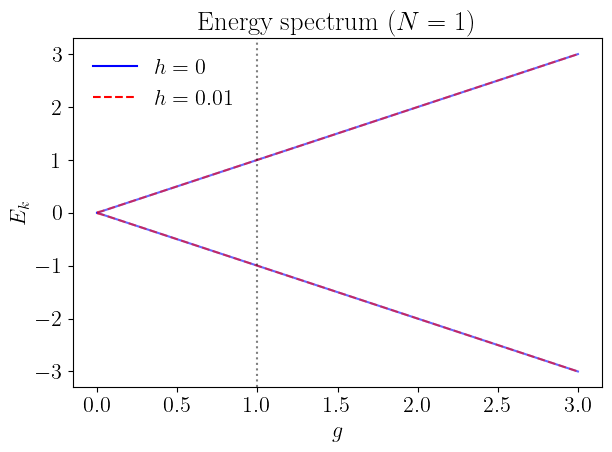

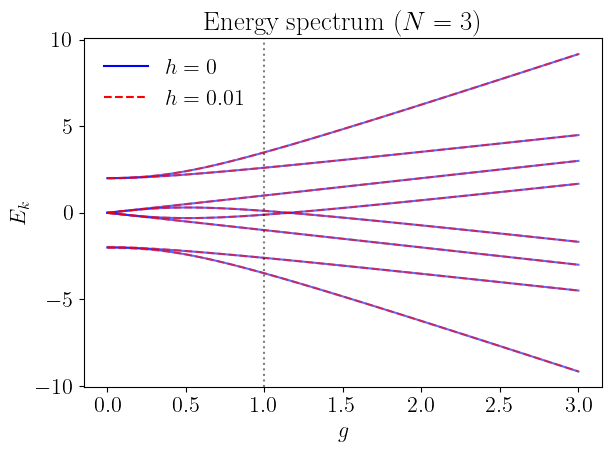

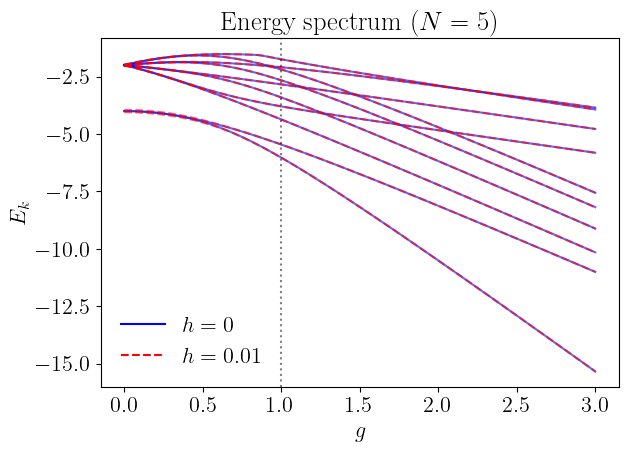

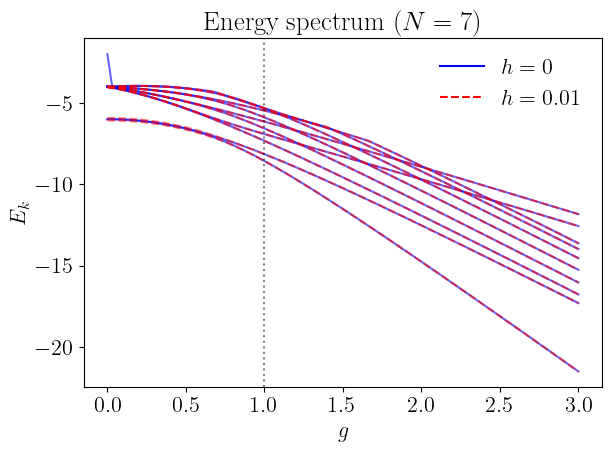

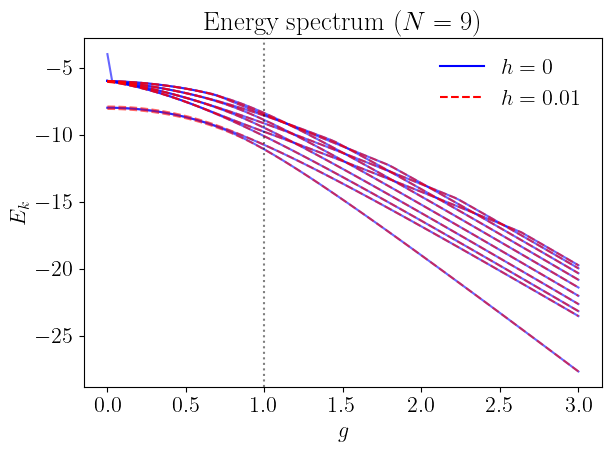

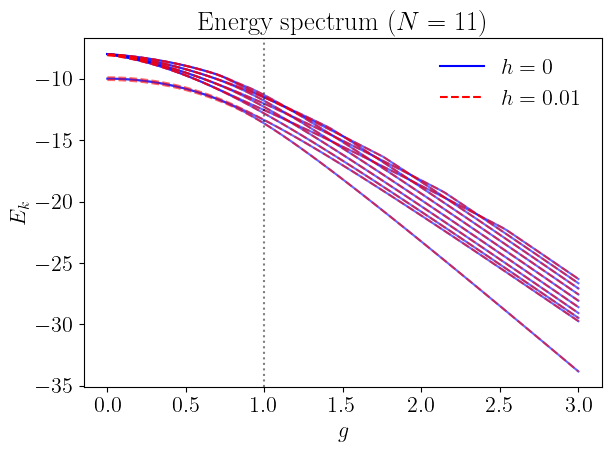

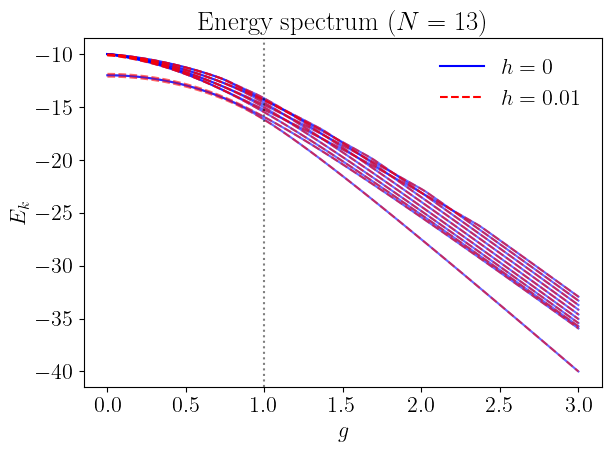

In [8]:
# Plot the results
for N in N_list:
    # Perform different plots
    fig, ax = plt.subplots()
    
    # Collect energy data
    data_h0 = results[(N, 0)] 
    data_h0001 = results[(N, 0.01)]
    
    # h=0 energy levels
    ax.plot(g_values, data_h0, color="blue", linestyle="-", alpha=0.6, linewidth=1.5)
    # Legend
    ax.plot([], [], color="blue", linestyle="-", label="$h=0$")


    # h=0.01 energy levels
    ax.plot(g_values, data_h0001, color="red", linestyle="--", alpha=0.6, linewidth=1.5)
    # Legend
    ax.plot([], [], color="red", linestyle="--", label="$h=0.01$")

    ax.set_title(f"Energy spectrum ($N={N}$)")
    ax.set_xlabel("$g$")
    ax.set_ylabel("$E_k$")
    ax.legend(frameon=False)
    
    # Critivcal point
    ax.axvline(x=1.0, color="black", linestyle=":", alpha=0.5, label="$g_c=1$")
    plt.tight_layout()
    plt.savefig(f"Energy_spectrum_N{N}.pdf")
    plt.show()

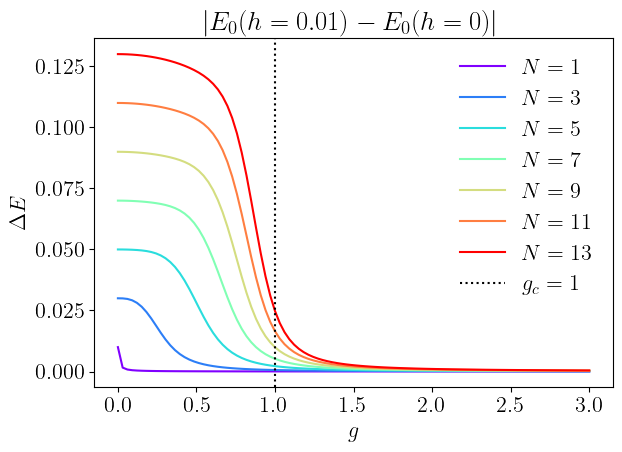

In [11]:
# Plot
cmap = plt.cm.rainbow
norm = plt.Normalize(min(N_list), max(N_list))

plt.figure()
for N_plot in N_list:
    # Compute energy difference
    E_h0 = results[(N_plot, 0)]     
    E_h001 = results[(N_plot, 0.01)] 
    diff_GS = np.abs(E_h001[:, 0] - E_h0[:, 0])

    plt.plot(g_values, diff_GS, linewidth=1.5, color=cmap(norm(N_plot)), label=rf"$N={N_plot}$")

plt.axvline(1, color="black", linestyle=":", label="$g_c=1$")

plt.title(r"$|E_0(h=0.01) - E_0(h=0)|$")
plt.xlabel(r"$g$")
plt.ylabel(r"$\Delta E$")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("Ediff.pdf")
plt.show()

In [6]:
# Compute magnetizations
magnetizations = {}

message_checkpoints(0, "Computing magnetizations...", True)
for N in N_list:
    print(f"Computing magnetizations for N: {N}/{N_list[-1]}")
    # Construct the Mz operator
    M = magnetization(N)
    
    for h in h_values:
        m_list = []
        
        for g in g_values:
            # Compute the GS
            H = ising_hamiltonian(N, g, h)
            psi0 = ground_state(H)
            
            # Compute <psi|M|psi>
            m = np.vdot(psi0, M.dot(psi0))
            m_list.append(np.real(m))
            
        magnetizations[(N, h)] = np.array(m_list)

message_checkpoints(0, "Computation done!", True)

Computing magnetizations...
Computing magnetizations for N: 1/13
Computing magnetizations for N: 3/13
Computing magnetizations for N: 5/13
Computing magnetizations for N: 7/13
Computing magnetizations for N: 9/13
Computing magnetizations for N: 11/13
Computing magnetizations for N: 13/13
Computation done!


### Compute the average magnetization

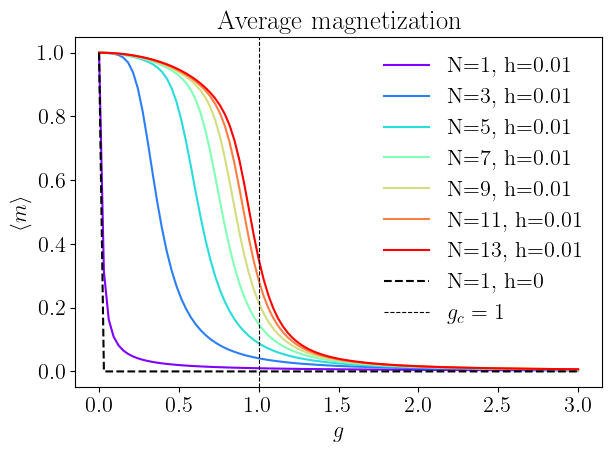

In [10]:
# Magnetization plot
fig, ax = plt.subplots()

cmap = plt.cm.rainbow
norm = plt.Normalize(min(N_list), max(N_list))

# Plot lines for h=0.01
for N in N_list:
    ax.plot(g_values, magnetizations[(N, 0.01)], linestyle='-', color=cmap(norm(N)), linewidth=1.5, label=rf"N={N}, h=0.01")

# Plot one random line for h=0
ax.plot(g_values, magnetizations[(1, 0)], linestyle='--', color="black", linewidth=1.5, label=rf"N=1, h=0")

ax.axvline(1.0, linewidth=0.8, linestyle="dashed", color="black", label=r"$g_c=1$")
ax.set_xlabel(r"$g$")
ax.set_ylabel(r"$\langle m \rangle$")
ax.set_title(r"Average magnetization")
ax.legend(loc="best", frameon=False)
plt.tight_layout()
plt.savefig("Magnetization.pdf")
plt.show()